In [1]:
#import modules we need to use for this session
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
# PCA module
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.metrics import r2_score

# Task 1. House price prediction using 311 data

### Can 311 complaining profile of urban neighborhoods enhance real-estate price prediction?

[Zhu, E., & Sobolevsky, S. (2018). House Price Modeling with Digital Census. arXiv preprint arXiv:1809.03834.]

Before we tried to use some parameters of the house (size) to predict its price. However notice that location matters as well. Below we upload a sample of more than 14000 individual house sales all around NYC in 2012. Each record together with the parameters of the house also contains important characteristics of the location (zip code) - average income of its residents (accodring to US census), as well as the relative structure of 311 complaints happening in the area.

In [2]:
folder=''

In [3]:
REsample=pd.read_csv(folder+'data/NYChome_sales2012.csv',index_col=0)

In [4]:
len(REsample)

14611

In [5]:
REsample.head()

,borough,neighborhood,block,lot,easement,building_class_present,address,zip_code,commmercial_units,land_sq_feet,gross_sq_feet,year_built,sale_price,sale_date
204018,4,LAURELTON,12941,94,NaN,A2,131-43 FRANCIS LEWIS BLVD,11413,0,3560,1473,1940,0,2012-01-01
217555,2,BATHGATE,3046,42,NaN,A1,2069 BATHGATE AVE,10457,0,1964,1424,1899,345376,2012-04-05
217598,2,BAYCHESTER,4707,70,NaN,A5,1134 EAST 213 STREET,10469,0,2320,1813,1950,335700,2012-05-17
217599,2,BAYCHESTER,4708,48,NaN,A5,1110 EAST 214TH STREET,10469,0,1710,1813,1945,338000,2012-02-03
217600,2,BAYCHESTER,4710,1,NaN,A5,1127 EAST 215TH STREET,10469,0,2759,1998,1945,0,2012-12-20


In [6]:
REsample.shape

(14611, 14)

In [7]:
REsample.columns

Index(['borough', 'neighborhood', 'block', 'lot', 'easement',
       'building_class_present', 'address', 'zip_code', 'commmercial_units',
       'land_sq_feet', 'gross_sq_feet', 'year_built', 'sale_price',
       'sale_date'],
      dtype='object')

In [8]:
#how many houses do we have per each borough?
np.bincount(REsample.borough)

array([   0,  216,  894, 2769, 7288, 3444])

In [9]:
#split into training (1), validation (2) and test (3) samples
np.random.seed(2018)
splitind=np.random.uniform(size=len(REsample))

In [10]:
REsample1=REsample.loc[splitind<=0.4] #Train Data
REsample2=REsample.loc[(splitind>0.4)&(splitind<0.7)] #Validation Data
REsample3=REsample.loc[(splitind>=0.7)] # Testing Data

In [11]:
len(REsample1) #loosing around 50 records within sparse zip codes

5832

In [12]:
len(REsample2)

4394

In [13]:
len(REsample3)

4385

In [14]:
# now load and curate 311 data which we're going to use in order to characterize the location

In [15]:
data311 = pd.read_csv(folder+'data/aggr311.csv', index_col = 0)
data311.head()

,Zip,Complain,Count
1,NaN,Adopt-A-Basket,5
2,10001,Adopt-A-Basket,1
3,10003,Adopt-A-Basket,1
4,10009,Adopt-A-Basket,1
5,10010,Adopt-A-Basket,1


In [16]:
data311.Zip=pd.to_numeric(data311.Zip,errors='coerce')

In [17]:
data311=data311.loc[(data311.Zip>=10000)&(data311.Zip<11500)] #take only NYC zip codes

In [18]:
data311=pd.pivot_table(data311,index='Zip',columns='Complain',values='Count',fill_value=0)

In [19]:
data311.head()

Complain,APPLIANCE,Adopt-A-Basket,Air Quality,Animal Abuse,Animal Facility - No Permit,Animal in a Park,Asbestos,BEST/Site Safety,Beach/Pool/Sauna Complaint,Bike Rack Condition,...,Unsanitary Pigeon Condition,Urinating in Public,Vacant Lot,Vending,Violation of Park Rules,Water Conservation,Water Quality,Water System,Window Guard,X-Ray Machine/Equipment
Zip,,,,,,,,,,,,,,,,,,,,,
10000.0,0,0,1,0,0,1,0,0,0,0,...,0,0,0,8,8,0,0,0,0,0
10001.0,0,1,90,0,0,1,20,36,1,1,...,3,0,2,51,5,5,2,366,0,0
10002.0,15,0,80,0,0,21,18,20,2,6,...,5,1,4,27,14,10,7,324,0,0
10003.0,15,1,143,0,2,44,24,13,2,2,...,7,11,2,54,25,12,5,318,0,0
10004.0,0,0,15,0,0,4,3,1,0,1,...,1,1,0,16,21,0,0,37,0,0


In [20]:
list_311=list(data311.columns)

In [21]:
Total311=data311.sum(axis= 1) #total 311 activity per zip code
data311=data311.div(data311.sum(axis= 1), axis= 0) #normalize activity of various cathegories within zip code by total
data311=data311.loc[Total311>100] #keep only those zip codes having sufficient activity

In [22]:
len(data311) #only 179 zip codes with reliable data left

179

In [23]:
data311.index.rename('zip_code', inplace = True)

In [24]:
data311.head()

Complain,APPLIANCE,Adopt-A-Basket,Air Quality,Animal Abuse,Animal Facility - No Permit,Animal in a Park,Asbestos,BEST/Site Safety,Beach/Pool/Sauna Complaint,Bike Rack Condition,...,Unsanitary Pigeon Condition,Urinating in Public,Vacant Lot,Vending,Violation of Park Rules,Water Conservation,Water Quality,Water System,Window Guard,X-Ray Machine/Equipment
zip_code,,,,,,,,,,,,,,,,,,,,,
10000.0,0.000000,0.000000,0.008772,0.0,0.000000,0.008772,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.070175,0.070175,0.000000,0.000000,0.000000,0.0,0.0
10001.0,0.000000,0.000146,0.013179,0.0,0.000000,0.000146,0.002929,0.005272,0.000146,0.000146,...,0.000439,0.000000,0.000293,0.007468,0.000732,0.000732,0.000293,0.053595,0.0,0.0
10002.0,0.001330,0.000000,0.007095,0.0,0.000000,0.001862,0.001596,0.001774,0.000177,0.000532,...,0.000443,0.000089,0.000355,0.002394,0.001242,0.000887,0.000621,0.028734,0.0,0.0
10003.0,0.001331,0.000089,0.012690,0.0,0.000177,0.003905,0.002130,0.001154,0.000177,0.000177,...,0.000621,0.000976,0.000177,0.004792,0.002218,0.001065,0.000444,0.028219,0.0,0.0
10004.0,0.000000,0.000000,0.009740,0.0,0.000000,0.002597,0.001948,0.000649,0.000000,0.000649,...,0.000649,0.000649,0.000000,0.010390,0.013636,0.000000,0.000000,0.024026,0.0,0.0


#### Q1. Run linear regression 'sale_price ~ gross_sq_feet+land_sq_feet+year_built' over the training data

In [25]:
REsample1.head()

,borough,neighborhood,block,lot,easement,building_class_present,address,zip_code,commmercial_units,land_sq_feet,gross_sq_feet,year_built,sale_price,sale_date
217555,2,BATHGATE,3046,42,NaN,A1,2069 BATHGATE AVE,10457,0,1964,1424,1899,345376,2012-04-05
217599,2,BAYCHESTER,4708,48,NaN,A5,1110 EAST 214TH STREET,10469,0,1710,1813,1945,338000,2012-02-03
217605,2,BAYCHESTER,4715,61,NaN,A9,1118 221ST STREET,10469,0,2514,1690,1950,250000,2012-12-17
217609,2,BAYCHESTER,4724,21,NaN,A1,3453 KINGSLAND AVENUE,10469,0,2283,1588,1910,249600,2012-06-01
217610,2,BAYCHESTER,4725,45,NaN,A9,1453 HICKS STREET,10469,0,1710,1690,1945,313000,2012-09-20


In [26]:
lr=smf.ols(formula = 'sale_price~gross_sq_feet+land_sq_feet+year_built', data = REsample1).fit()
print(lr.summary())

                            OLS Regression Results                            
Dep. Variable:             sale_price   R-squared:                       0.150
Model:                            OLS   Adj. R-squared:                  0.150
Method:                 Least Squares   F-statistic:                     342.8
Date:                Thu, 21 Nov 2019   Prob (F-statistic):          5.23e-205
Time:                        00:52:18   Log-Likelihood:                -88308.
No. Observations:                5832   AIC:                         1.766e+05
Df Residuals:                    5828   BIC:                         1.767e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      7.637e+06   8.92e+05      8.561

#### Q2. Add 311 data corresponding to the zip code of the house location to REsample1,2,3 
in order to characterize the house's neighborhood by merging the dataframes REsample1,2,3 with data311 by zip code. Name merged dataframes REsample1_311, REsample2_311, REsample3_311 
rename 311 columns to F1,F2,... for easier formulae engineering
but keep the original names as a dictionary {'F1':'APPLIANCE', ...}

In [27]:
data311.index.names = ['zip_code']
data311.head()

Complain,APPLIANCE,Adopt-A-Basket,Air Quality,Animal Abuse,Animal Facility - No Permit,Animal in a Park,Asbestos,BEST/Site Safety,Beach/Pool/Sauna Complaint,Bike Rack Condition,...,Unsanitary Pigeon Condition,Urinating in Public,Vacant Lot,Vending,Violation of Park Rules,Water Conservation,Water Quality,Water System,Window Guard,X-Ray Machine/Equipment
zip_code,,,,,,,,,,,,,,,,,,,,,
10000.0,0.000000,0.000000,0.008772,0.0,0.000000,0.008772,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.070175,0.070175,0.000000,0.000000,0.000000,0.0,0.0
10001.0,0.000000,0.000146,0.013179,0.0,0.000000,0.000146,0.002929,0.005272,0.000146,0.000146,...,0.000439,0.000000,0.000293,0.007468,0.000732,0.000732,0.000293,0.053595,0.0,0.0
10002.0,0.001330,0.000000,0.007095,0.0,0.000000,0.001862,0.001596,0.001774,0.000177,0.000532,...,0.000443,0.000089,0.000355,0.002394,0.001242,0.000887,0.000621,0.028734,0.0,0.0
10003.0,0.001331,0.000089,0.012690,0.0,0.000177,0.003905,0.002130,0.001154,0.000177,0.000177,...,0.000621,0.000976,0.000177,0.004792,0.002218,0.001065,0.000444,0.028219,0.0,0.0
10004.0,0.000000,0.000000,0.009740,0.0,0.000000,0.002597,0.001948,0.000649,0.000000,0.000649,...,0.000649,0.000649,0.000000,0.010390,0.013636,0.000000,0.000000,0.024026,0.0,0.0


In [28]:
data311.shape

(179, 162)

In [29]:
F = []

for f in range(1,163):
    F.append('F{}'.format(f))

dico_complaints= dict(zip(F,data311.columns))

In [30]:
data311.columns= F
data311.head()

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,...,F153,F154,F155,F156,F157,F158,F159,F160,F161,F162
zip_code,,,,,,,,,,,,,,,,,,,,,
10000.0,0.000000,0.000000,0.008772,0.0,0.000000,0.008772,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.070175,0.070175,0.000000,0.000000,0.000000,0.0,0.0
10001.0,0.000000,0.000146,0.013179,0.0,0.000000,0.000146,0.002929,0.005272,0.000146,0.000146,...,0.000439,0.000000,0.000293,0.007468,0.000732,0.000732,0.000293,0.053595,0.0,0.0
10002.0,0.001330,0.000000,0.007095,0.0,0.000000,0.001862,0.001596,0.001774,0.000177,0.000532,...,0.000443,0.000089,0.000355,0.002394,0.001242,0.000887,0.000621,0.028734,0.0,0.0
10003.0,0.001331,0.000089,0.012690,0.0,0.000177,0.003905,0.002130,0.001154,0.000177,0.000177,...,0.000621,0.000976,0.000177,0.004792,0.002218,0.001065,0.000444,0.028219,0.0,0.0
10004.0,0.000000,0.000000,0.009740,0.0,0.000000,0.002597,0.001948,0.000649,0.000000,0.000649,...,0.000649,0.000649,0.000000,0.010390,0.013636,0.000000,0.000000,0.024026,0.0,0.0


In [31]:
dico_complaints['F120']

'STRUCTURAL'

In [32]:
REsample1_311=REsample1.merge(data311,on= 'zip_code')
REsample1_311.set_index('zip_code', inplace=True)
REsample1_311.head()

,borough,neighborhood,block,lot,easement,building_class_present,address,commmercial_units,land_sq_feet,gross_sq_feet,...,F153,F154,F155,F156,F157,F158,F159,F160,F161,F162
zip_code,,,,,,,,,,,,,,,,,,,,,
10457,2,BATHGATE,3046,42,NaN,A1,2069 BATHGATE AVE,0,1964,1424,...,0.000161,0.000268,0.000321,0.000428,0.000482,0.000803,0.000268,0.028311,0.000000,0.0
10457,2,MOUNT HOPE/MOUNT EDEN,2790,53,NaN,A1,1693 CLAY AVENUE,0,3610,1998,...,0.000161,0.000268,0.000321,0.000428,0.000482,0.000803,0.000268,0.028311,0.000000,0.0
10457,2,MOUNT HOPE/MOUNT EDEN,2791,36,NaN,A1,1690 MONROE AVENUE,0,2375,1617,...,0.000161,0.000268,0.000321,0.000428,0.000482,0.000803,0.000268,0.028311,0.000000,0.0
10457,2,MOUNT HOPE/MOUNT EDEN,2802,33,NaN,A1,258 MOUNT HOPE PLACE,0,2375,1825,...,0.000161,0.000268,0.000321,0.000428,0.000482,0.000803,0.000268,0.028311,0.000000,0.0
10469,2,BAYCHESTER,4708,48,NaN,A5,1110 EAST 214TH STREET,0,1710,1813,...,0.000405,0.000202,0.001619,0.000202,0.000101,0.004959,0.000708,0.046250,0.000101,0.0


In [33]:
REsample2_311=REsample2.merge(data311,on= 'zip_code')
REsample2_311.set_index('zip_code', inplace=True)
REsample2_311.head()

,borough,neighborhood,block,lot,easement,building_class_present,address,commmercial_units,land_sq_feet,gross_sq_feet,...,F153,F154,F155,F156,F157,F158,F159,F160,F161,F162
zip_code,,,,,,,,,,,,,,,,,,,,,
10469,2,BAYCHESTER,4710,1,NaN,A5,1127 EAST 215TH STREET,0,2759,1998,...,0.000405,0.000202,0.001619,0.000202,0.000101,0.004959,0.000708,0.04625,0.000101,0.0
10469,2,BAYCHESTER,4710,1,NaN,A5,1127 EAST 215TH STREET,0,2759,1998,...,0.000405,0.000202,0.001619,0.000202,0.000101,0.004959,0.000708,0.04625,0.000101,0.0
10469,2,BAYCHESTER,4715,22,NaN,A5,1156 EAST 221 STREET,0,1842,1744,...,0.000405,0.000202,0.001619,0.000202,0.000101,0.004959,0.000708,0.04625,0.000101,0.0
10469,2,BAYCHESTER,4730,10,NaN,A1,1320 EAST 222 STREET,0,1938,1974,...,0.000405,0.000202,0.001619,0.000202,0.000101,0.004959,0.000708,0.04625,0.000101,0.0
10469,2,BAYCHESTER,4730,45,NaN,A5,3418 GUNTHER AVENUE,0,1710,1890,...,0.000405,0.000202,0.001619,0.000202,0.000101,0.004959,0.000708,0.04625,0.000101,0.0


In [34]:
REsample3_311=REsample3.merge(data311,on='zip_code')
REsample3_311.set_index('zip_code', inplace= True)
REsample3_311.head()

,borough,neighborhood,block,lot,easement,building_class_present,address,commmercial_units,land_sq_feet,gross_sq_feet,...,F153,F154,F155,F156,F157,F158,F159,F160,F161,F162
zip_code,,,,,,,,,,,,,,,,,,,,,
11413,4,LAURELTON,12941,94,NaN,A2,131-43 FRANCIS LEWIS BLVD,0,3560,1473,...,0.0,0.0,0.004396,0.0,0.000176,0.007209,0.001231,0.067698,0.0,0.0
11413,4,LAURELTON,12825,209,NaN,A2,121-12 FRANCIS LEWIS BLVD,0,4240,1231,...,0.0,0.0,0.004396,0.0,0.000176,0.007209,0.001231,0.067698,0.0,0.0
11413,4,LAURELTON,12825,256,NaN,A2,128-26 FRANCIS LEWIS BLVD,0,3817,1094,...,0.0,0.0,0.004396,0.0,0.000176,0.007209,0.001231,0.067698,0.0,0.0
11413,4,LAURELTON,12825,344,NaN,A2,226-57 129TH AVENUE,0,5000,1148,...,0.0,0.0,0.004396,0.0,0.000176,0.007209,0.001231,0.067698,0.0,0.0
11413,4,LAURELTON,12825,356,NaN,A2,226-33 129TH AVENUE,0,4720,1148,...,0.0,0.0,0.004396,0.0,0.000176,0.007209,0.001231,0.067698,0.0,0.0


#### Q3. Run the linear model with 311
We need to add 311 features in addition to the gross_sq_feet,land_sq_feet,year_built used before. So regression will include both - house characteristics as well as 311 features of the location
Train the model over the training sample REsample1_311 and test over the test sample REsample3_311,
report training and test R2

In [35]:
mlr=smf.ols(formula='sale_price~gross_sq_feet+land_sq_feet+year_built+'+'+'.join(['F{}'.format(p) for p in range(1,163)]), data = REsample1_311).fit()
results=pd.Series()
results=mlr.predict()
print(mlr.summary())

                            OLS Regression Results                            
Dep. Variable:             sale_price   R-squared:                       0.448
Model:                            OLS   Adj. R-squared:                  0.433
Method:                 Least Squares   F-statistic:                     30.23
Date:                Thu, 21 Nov 2019   Prob (F-statistic):               0.00
Time:                        00:52:19   Log-Likelihood:                -85271.
No. Observations:                5710   AIC:                         1.708e+05
Df Residuals:                    5560   BIC:                         1.718e+05
Df Model:                         149                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -1.873e+08    6.1e+07     -3.071

In [36]:
print('The R2 for the Test set is: {}'.format(r2_score(REsample1_311.sale_price, results)))
print('The R2 for the Test set is: {}'.format(r2_score(REsample3_311.sale_price, mlr.predict(REsample3_311))))

The R2 for the Test set is: 0.44755585866664505
The R2 for the Test set is: 0.2788057467666969


#### Q4. Apply regularization
Train Ridge and Lasso over REsample1_311 with an arbitrary default parameter $\alpha=1$.
Then evaluate their out-of-sample performance over REsample3_311
Make sure to scale the features in all three samples first, learning the scaler over the training sample

In [37]:
REsample1_311.iloc[:,np.r_[8:11,13:175]].head()

,land_sq_feet,gross_sq_feet,year_built,F1,F2,F3,F4,F5,F6,F7,...,F153,F154,F155,F156,F157,F158,F159,F160,F161,F162
zip_code,,,,,,,,,,,,,,,,,,,,,
10457,1964,1424,1899,0.007921,0.0,0.001980,0.002087,0.000000,0.000589,0.000321,...,0.000161,0.000268,0.000321,0.000428,0.000482,0.000803,0.000268,0.028311,0.000000,0.0
10457,3610,1998,1901,0.007921,0.0,0.001980,0.002087,0.000000,0.000589,0.000321,...,0.000161,0.000268,0.000321,0.000428,0.000482,0.000803,0.000268,0.028311,0.000000,0.0
10457,2375,1617,1910,0.007921,0.0,0.001980,0.002087,0.000000,0.000589,0.000321,...,0.000161,0.000268,0.000321,0.000428,0.000482,0.000803,0.000268,0.028311,0.000000,0.0
10457,2375,1825,1905,0.007921,0.0,0.001980,0.002087,0.000000,0.000589,0.000321,...,0.000161,0.000268,0.000321,0.000428,0.000482,0.000803,0.000268,0.028311,0.000000,0.0
10469,1710,1813,1945,0.004757,0.0,0.001822,0.003643,0.000101,0.000405,0.001316,...,0.000405,0.000202,0.001619,0.000202,0.000101,0.004959,0.000708,0.046250,0.000101,0.0


In [38]:
from sklearn.preprocessing import StandardScaler
scaler= StandardScaler()
print(scaler.fit(REsample1_311.iloc[:,np.r_[8:11,13:175]]))
s1= pd.DataFrame(data = scaler.transform(REsample1_311.iloc[:,np.r_[8:11,13:175]]))
s1.head()

StandardScaler(copy=True, with_mean=True, with_std=True)


,0,1,2,3,4,5,6,7,8,9,...,155,156,157,158,159,160,161,162,163,164
0,-0.511684,-0.363242,-1.670148,3.536791,-0.33732,-0.349889,2.023878,-0.484506,-0.288705,-1.028000,...,-0.674489,0.240013,-0.993202,-0.453794,-0.174616,-0.719220,-1.423950,-0.937317,-0.278564,-0.208705
1,0.027234,0.250535,-1.593605,3.536791,-0.33732,-0.349889,2.023878,-0.484506,-0.288705,-1.028000,...,-0.674489,0.240013,-0.993202,-0.453794,-0.174616,-0.719220,-1.423950,-0.937317,-0.278564,-0.208705
2,-0.377118,-0.156867,-1.249161,3.536791,-0.33732,-0.349889,2.023878,-0.484506,-0.288705,-1.028000,...,-0.674489,0.240013,-0.993202,-0.453794,-0.174616,-0.719220,-1.423950,-0.937317,-0.278564,-0.208705
3,-0.377118,0.065546,-1.440518,3.536791,-0.33732,-0.349889,2.023878,-0.484506,-0.288705,-1.028000,...,-0.674489,0.240013,-0.993202,-0.453794,-0.174616,-0.719220,-1.423950,-0.937317,-0.278564,-0.208705
4,-0.594846,0.052715,0.090344,1.569568,-0.33732,-0.401566,3.711501,0.104550,-0.408367,0.380015,...,-0.071134,-0.041563,-0.559839,-0.589761,-0.453192,-0.082653,-0.750075,-0.155093,1.146895,-0.208705


In [39]:
print(scaler.fit(REsample2_311.iloc[:,np.r_[8:11,13:175]]))
s2= pd.DataFrame(data = scaler.transform(REsample2_311.iloc[:,np.r_[8:11,13:175]]))
s2.head()

StandardScaler(copy=True, with_mean=True, with_std=True)


,0,1,2,3,4,5,6,7,8,9,...,155,156,157,158,159,160,161,162,163,164
0,-0.269618,0.235217,0.090895,1.542556,-0.321864,-0.378945,3.694399,0.161086,-0.383111,0.362028,...,-0.10023,-0.005339,-0.575223,-0.62752,-0.425236,-0.093224,-0.787975,-0.164609,1.014042,-0.221335
1,-0.269618,0.235217,0.090895,1.542556,-0.321864,-0.378945,3.694399,0.161086,-0.383111,0.362028,...,-0.10023,-0.005339,-0.575223,-0.62752,-0.425236,-0.093224,-0.787975,-0.164609,1.014042,-0.221335
2,-0.590295,-0.020270,0.282678,1.542556,-0.321864,-0.378945,3.694399,0.161086,-0.383111,0.362028,...,-0.10023,-0.005339,-0.575223,-0.62752,-0.425236,-0.093224,-0.787975,-0.164609,1.014042,-0.221335
3,-0.556723,0.211077,-1.596796,1.542556,-0.321864,-0.378945,3.694399,0.161086,-0.383111,0.362028,...,-0.10023,-0.005339,-0.575223,-0.62752,-0.425236,-0.093224,-0.787975,-0.164609,1.014042,-0.221335
4,-0.636456,0.126585,0.282678,1.542556,-0.321864,-0.378945,3.694399,0.161086,-0.383111,0.362028,...,-0.10023,-0.005339,-0.575223,-0.62752,-0.425236,-0.093224,-0.787975,-0.164609,1.014042,-0.221335


In [40]:
print(scaler.fit(REsample3_311.iloc[:,np.r_[8:11,13:175]]))
s3= pd.DataFrame(data = scaler.transform(REsample3_311.iloc[:,np.r_[8:11,13:175]]))
s3.head()

StandardScaler(copy=True, with_mean=True, with_std=True)


,0,1,2,3,4,5,6,7,8,9,...,155,156,157,158,159,160,161,162,163,164
0,0.013170,-0.314853,-0.106473,-0.18155,-0.325174,-0.204829,-0.240026,-0.490608,0.029391,-1.045944,...,-1.099272,-0.917064,0.363661,-0.723418,-0.390894,0.293967,0.042067,0.807665,-0.28807,-0.221151
1,0.201010,-0.571977,0.087090,-0.18155,-0.325174,-0.204829,-0.240026,-0.490608,0.029391,-1.045944,...,-1.099272,-0.917064,0.363661,-0.723418,-0.390894,0.293967,0.042067,0.807665,-0.28807,-0.221151
2,0.084162,-0.717538,0.087090,-0.18155,-0.325174,-0.204829,-0.240026,-0.490608,0.029391,-1.045944,...,-1.099272,-0.917064,0.363661,-0.723418,-0.390894,0.293967,0.042067,0.807665,-0.28807,-0.221151
3,0.410949,-0.660163,0.087090,-0.18155,-0.325174,-0.204829,-0.240026,-0.490608,0.029391,-1.045944,...,-1.099272,-0.917064,0.363661,-0.723418,-0.390894,0.293967,0.042067,0.807665,-0.28807,-0.221151
4,0.333603,-0.660163,0.087090,-0.18155,-0.325174,-0.204829,-0.240026,-0.490608,0.029391,-1.045944,...,-1.099272,-0.917064,0.363661,-0.723418,-0.390894,0.293967,0.042067,0.807665,-0.28807,-0.221151


In [41]:
Lasso=linear_model.Lasso(fit_intercept=True, alpha=1)
Lasso.fit(s1,REsample1_311.sale_price)

# In Sample:
YPred_IS=Lasso.predict(s1)
print("The IS R-squared of Lasso is: {0}".format(r2_score(REsample1_311.sale_price,YPred_IS)))
#Out of Sample:
YPred_OS=Lasso.predict(s3)
print("The OS R-squared of Lasso is: {0}".format(r2_score(REsample3_311.sale_price,YPred_OS)))
Lasso.coef_

The IS R-squared of Lasso is: 0.44708559740092446
The OS R-squared of Lasso is: 0.2601348211229212


//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1550496962991418.5, tolerance: 566321910152.5015
  positive)


array([  22214.90736185,  149346.97079426,   -2018.68266753,
        129876.6604196 , -221754.54046668,  -30757.97656493,
        159442.18567537, -223304.58478631, -311368.47886018,
         46204.14426656,  -15626.75958651, -140744.70022424,
        181522.81632825,  -68656.70265788, -129313.02135242,
        194102.65503812,  229172.97545639,   82973.93862191,
        645841.6669078 , -163442.20718593,   52818.51283378,
        115294.38845325,   66082.78017007, -155076.23965296,
         -7469.00004872,  132130.10550197, -120621.83200473,
       -289414.78162316, -112211.37777571, -272012.90783122,
        -79521.15867142,  378960.59465978,  211349.4681758 ,
         39282.0049327 ,  -83240.50610107, -226322.07647807,
        -42171.79212024,  -67470.56659859,  396845.43533672,
        -67490.16260205,   43364.27595477, -148821.38406208,
         78858.68673676,   77989.3636915 ,  -98165.78382514,
        241822.17945652,  134580.37019117, -206562.4348476 ,
       -199109.43912262,

In [42]:
Ridge=linear_model.Ridge(fit_intercept=True, alpha=1)
Ridge.fit(s1,REsample1_311.sale_price)

# In Sample:
YPred_IS2=Ridge.predict(s1)
print("The IS R-squared of Ridge is: {0}".format(r2_score(REsample1_311.sale_price,YPred_IS2)))
#Out of Sample:
YPred_OS2=Ridge.predict(s3)
print("The OS R-squared of Ridge is: {0}".format(r2_score(REsample3_311.sale_price,YPred_OS2)))
Ridge.coef_

The IS R-squared of Ridge is: 0.4474127557968046
The OS R-squared of Ridge is: 0.2684490000823132


array([  21908.00110352,  149861.4834251 ,   -1855.44932524,
        109156.01081156, -169844.26849974,   14593.53281215,
        212752.10329312, -204263.58947647, -240693.43213615,
          4609.49279952,  -76140.27091377, -228203.68257301,
        152429.80710409, -147059.07563535,   23007.80346304,
        184474.55069015,  265105.41491383,   38571.62417408,
        631625.76250266, -114319.77176002,   58483.0244137 ,
         36768.08381723,   62585.97793463, -109389.78293947,
        -58398.69003557,  191649.73279804, -123671.58645304,
       -282708.44666979,  -34464.30373775, -197440.08223258,
        -11473.02245096,  378631.04166124,  184923.47856446,
       -117553.20656695,  118337.26083613, -248499.64206748,
        -73364.45261153,  -28459.06058203,  399102.94045781,
       -127201.03428562, -102875.72684933, -222195.47598939,
         86861.28060938,  203618.96906246,  -40844.0734269 ,
        299396.45967077,   85675.38052945, -142041.84158741,
       -242936.932313  ,

#### Q5. Perform parameter selection for Lasso and Ridge over validation sample
try exponential range -exp(10)...exp(20) with 100 values in it

Visualize the validation R2 vs alpha

For the optimal alpha evaluate performance of the models over the test set

In [43]:
#Find the Alpha and report best test performance for Ridge/Lasso.
# L1 Regularization is Lasso and L2 is Ridge
def Regularization_fit_alpha(model,X_train,y_train,X_valid,y_valid,alphas,Graph=False, logl=False):
    #Model = 1-Ridge, 2-Lasso
    #Aplhas: a list of aplha values to try
    #Graph: plot the graph of R^2 values for different alpha

    R_2_OS=[] #OS R2
    
    #initialize the model to use for each given alpha
    if model==1:
        RM = lambda a: linear_model.Ridge(fit_intercept=True, alpha=a)
        model_label='Lasso'
    else:
        RM = lambda a: linear_model.Lasso(fit_intercept=True, alpha=a)
        model_label='Ridge'
    
    best_R2 = -1
    best_alpha = alphas[0]
    best_coefs = []
    
    for a in alphas: #for all alphas to try
        lm = RM(a) #assign the model
        lm.fit(X_train,y_train)  #fit the regularization model
        y_predict=lm.predict(X_valid) #compute the prediction for the validation sample 
        R_2_OS_=r2_score(y_valid,y_predict)
        R_2_OS.append(R_2_OS_)
        if R_2_OS_ > best_R2: #if current OS R2 is the best - update the best solution
            best_R2 = R_2_OS_
            best_alpha = a
            best_coefs = lm.coef_
    
    if Graph==True: #visualization of the performance depending on alpha
        plt.title('OS-R-squared for different Alpha')
        if logl: #log-scale
            plt.xlabel('ln(Alpha)')
            l=np.log(alphas)
            bl=np.log(best_alpha)
        else:
            plt.xlabel('Alpha')
            l=alphas
            bl=best_alpha
        plt.ylim((-0.1,1))
        plt.plot(l,R_2_OS,'b',label=model_label)
        plt.legend(loc='upper right')
        plt.ylabel('R-squared')
        plt.axvline(bl,color='r',linestyle='--')

        plt.show()
    
    return [best_alpha,best_R2,best_coefs]

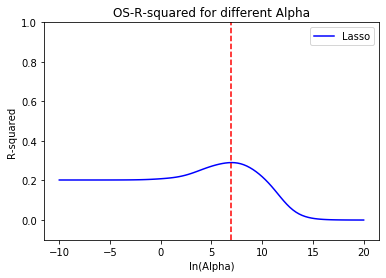

Optimal alpha for Lasso=1063.900307652953, best OS R_2=0.2906255123070588


In [44]:
# L1 Regularization is Lasso and L2 is Ridge

alphas = np.exp(np.linspace(-10,20,100)) #exponential range of possible alphas
[alpha_optimal_L1, best_R2_L1, best_coefs_L1]=Regularization_fit_alpha(1,s1,REsample1_311.sale_price,s2,REsample2_311.sale_price,alphas,Graph=True,logl=True)
print('Optimal alpha for Lasso={0}, best OS R_2={1}'.format(alpha_optimal_L1,best_R2_L1))

In [45]:
Lasso=linear_model.Lasso(fit_intercept=True, alpha=alpha_optimal_L1)
Lasso.fit(s1,REsample1_311.sale_price)

# In sample:
YPred_IS_L1=Lasso.predict(s1)
print("The IS R-squared of Lasso is: {0}".format(r2_score(REsample1_311.sale_price,YPred_IS_L1)))
#Out of sample:
YPred_OS_L1=Lasso.predict(s3)
print("The OS R-squared of Lasso is: {0}".format(r2_score(REsample3_311.sale_price,YPred_OS_L1)))
Lasso.coef_

The IS R-squared of Lasso is: 0.4391585370981542
The OS R-squared of Lasso is: 0.2862203306049893


array([  19787.45532438,  156575.4449326 ,   -4435.26110192,
             0.        ,  -79191.18827644,      -0.        ,
             0.        ,      -0.        , -152589.98335009,
          2011.49080175,       0.        ,  -61747.09203629,
         95481.31135311,  -37442.48130266,  -59737.02525961,
          9138.31016174,  179498.88025902,   74550.70682811,
        380557.07255513,  -96578.86703348,   17867.34213782,
             0.        ,  -27279.37092616, -138674.22485485,
        -53213.2771061 ,   70362.38576064,       0.        ,
            -0.        ,  -65999.66258806, -100493.20741869,
            -0.        ,  476898.09989959,   71543.55034189,
         21134.10676933,       0.        , -158225.66288439,
             0.        ,  -76016.46635214,  157551.39185331,
        -50630.50567575,  -12974.5737078 ,   36740.00115533,
       -174581.09433011,   68868.56123293,   13307.68831424,
        128436.08702293,   60579.39099125,  -73903.86020219,
        -26442.92714915,

//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1565635642970860.0, tolerance: 566321910152.5015
  positive)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1565635398702258.5, tolerance: 566321910152.5015
  positive)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1565635067973475.0, tolerance: 566321910152.5015
  positive)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 156563462

//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1554443097362901.0, tolerance: 566321910152.5015
  positive)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1550496962991418.5, tolerance: 566321910152.5015
  positive)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1545166844138977.2, tolerance: 566321910152.5015
  positive)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 153797265

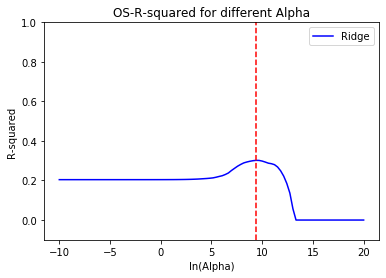

Optimal alpha for Ridge=12015.339377705404, best OS R_2=0.3019445009642199


In [46]:
alphas = np.exp(np.linspace(-10,20,100)) #exponential range of possible alphas
[alpha_optimal_L2, best_R2_L2, best_coefs_L2]=Regularization_fit_alpha(2,s1,REsample1_311.sale_price,s2,REsample2_311.sale_price,alphas,Graph=True,logl=True)
print('Optimal alpha for Ridge={0}, best OS R_2={1}'.format(alpha_optimal_L2,best_R2_L2))

In [47]:
Ridge=linear_model.Ridge(fit_intercept=True, alpha=alpha_optimal_L2)
Ridge.fit(s1,REsample1_311.sale_price)

# In sample:
YPred_IS_L2=Ridge.predict(s1)
print("The IS R-squared of Ridge is: {0}".format(r2_score(REsample1_311.sale_price,YPred_IS_L2)))
#Out of sample:
YPred_OS_L2=Ridge.predict(s3)
print("The OS R-squared of Ridge is: {0}".format(r2_score(REsample3_311.sale_price,YPred_OS_L2)))
Ridge.coef_

The IS R-squared of Ridge is: 0.30622018401742623
The OS R-squared of Ridge is: 0.34449034739222084


array([ 1.40067429e+04,  6.46760642e+04, -1.94020742e+03, -3.20121248e+03,
       -1.12147140e+04,  2.51374926e+04, -6.77463422e+03,  2.81943760e+03,
        3.81776620e+03,  7.19503312e+03,  1.09885726e+04, -1.03114455e+04,
        1.51956125e+04,  1.17575117e+04, -1.54301404e+04,  6.13101069e+03,
        1.47493755e+02, -4.84180947e+03,  2.92655497e+04,  3.04964819e+03,
        2.91952943e+04, -4.39313736e+03,  7.78183863e+02, -1.77190910e+03,
       -2.18824923e+03,  2.08458829e+03,  3.53517105e+03, -3.98461216e+03,
       -2.12815278e+03, -5.80222668e+03, -4.94198124e+03,  8.35196112e+04,
        1.41850257e+04, -9.81011581e+01, -4.14507768e+02,  4.52730770e+03,
       -3.15327616e+03, -8.75043537e+03,  1.33114859e+03, -6.17145348e+03,
       -7.41251624e+03,  2.16982915e+03,  3.43858449e+03, -2.42172565e+03,
       -5.89330442e+03, -5.68526667e+03, -2.56378825e+03, -1.41118435e+03,
       -1.22635528e+03,  3.00131331e+03, -9.13443653e+03, -1.57493252e+03,
        3.95353410e+03,  

#### Task 2. Model Mean income of the zip code population using 311 profile of the neighborhood

In [48]:
#load the data
dataIncome=pd.read_csv(folder+"data/MeanZip.csv",index_col=0)
dataIncome=dataIncome.apply(pd.to_numeric, errors='coerce')
dataIncome=dataIncome.loc[dataIncome.Mean>0]
dataIncome.index.name='zip_code'
dataIncome.head()

,Median,Mean,Pop
zip_code,,,
1001,56662.5735,66687.7509,16445
1002,49853.4177,75062.6343,28069
1003,28462.0000,35121.0000,8491
1005,75423.0000,82442.0000,4798
1007,79076.3540,85801.9750,12962


In [49]:
dataIncome = dataIncome.iloc[:,[1,0,2]]
dataIncome.head()

,Mean,Median,Pop
zip_code,,,
1001,66687.7509,56662.5735,16445
1002,75062.6343,49853.4177,28069
1003,35121.0000,28462.0000,8491
1005,82442.0000,75423.0000,4798
1007,85801.9750,79076.3540,12962


In [50]:
data_income = dataIncome.merge(data311, on= 'zip_code')
data_income.head()

,Mean,Median,Pop,F1,F2,F3,F4,F5,F6,F7,...,F153,F154,F155,F156,F157,F158,F159,F160,F161,F162
zip_code,,,,,,,,,,,,,,,,,,,,,
10001,123112.7764,71244.6100,17678,0.000000,0.000146,0.013179,0.0,0.000000,0.000146,0.002929,...,0.000439,0.000000,0.000293,0.007468,0.000732,0.000732,0.000293,0.053595,0.0,0.0
10002,46258.6118,30843.9574,70878,0.001330,0.000000,0.007095,0.0,0.000000,0.001862,0.001596,...,0.000443,0.000089,0.000355,0.002394,0.001242,0.000887,0.000621,0.028734,0.0,0.0
10003,139330.9968,89998.5339,53609,0.001331,0.000089,0.012690,0.0,0.000177,0.003905,0.002130,...,0.000621,0.000976,0.000177,0.004792,0.002218,0.001065,0.000444,0.028219,0.0,0.0
10004,156682.7615,110183.6857,1271,0.000000,0.000000,0.009740,0.0,0.000000,0.002597,0.001948,...,0.000649,0.000649,0.000000,0.010390,0.013636,0.000000,0.000000,0.024026,0.0,0.0
10005,163762.6601,115133.2855,1517,0.000000,0.000000,0.008219,0.0,0.000000,0.002192,0.000548,...,0.000000,0.000000,0.000000,0.013699,0.000000,0.000548,0.000000,0.019726,0.0,0.0


In [51]:
#split into training (1), validation (2) and test (3) samples
np.random.seed(1234)
splitind=np.random.uniform(size=len(data_income))
dataIncome1=data_income.loc[splitind<=0.4] 
dataIncome2=data_income.loc[(splitind>0.4)&(splitind<0.7)]
dataIncome3=data_income.loc[(splitind>=0.7)] 


In [52]:
dataIncome1_mean=dataIncome1.Mean
dataIncome2_mean=dataIncome2.Mean
dataIncome3_mean=dataIncome3.Mean
dataIncome1_mean.head()

zip_code
10001    123112.7764
10006    156776.0000
10007    256235.5719
10012    135998.6472
10017    149723.7834
Name: Mean, dtype: float64

In [53]:
dataIncome1.drop(labels= ['Mean','Median','Pop'], axis= 1, inplace = True)
dataIncome2.drop(labels= ['Mean','Median','Pop'], axis= 1, inplace = True)
dataIncome3.drop(labels= ['Mean','Median','Pop'], axis= 1, inplace = True)

//anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


#### Q1. Perform regularied regression of Mean income of the zip code vs its 311 profile 
Train Ridge and Lasso over dataIncome1 with an arbitrary default parameter $\alpha=100$.
Then evaluate their out-of-sample performance over dataIncome3
Make sure to scale the features in all three samples first, learning the scaler over the training sample

In [54]:
dataIncome1.head()

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,...,F153,F154,F155,F156,F157,F158,F159,F160,F161,F162
zip_code,,,,,,,,,,,,,,,,,,,,,
10001,0.000000,0.000146,0.013179,0.0,0.0,0.000146,0.002929,0.005272,0.000146,0.000146,...,0.000439,0.000000,0.000293,0.007468,0.000732,0.000732,0.000293,0.053595,0.0,0.0
10006,0.000000,0.000000,0.016667,0.0,0.0,0.000000,0.003846,0.003846,0.000000,0.000000,...,0.000000,0.001282,0.000000,0.008974,0.000000,0.001282,0.001282,0.032051,0.0,0.0
10007,0.000000,0.000000,0.015152,0.0,0.0,0.000410,0.001229,0.004914,0.000000,0.000000,...,0.000819,0.000000,0.000000,0.015561,0.005733,0.000410,0.000819,0.042588,0.0,0.0
10012,0.000562,0.000844,0.011389,0.0,0.0,0.001265,0.002812,0.001406,0.000000,0.000281,...,0.000422,0.000281,0.000141,0.019263,0.000281,0.000562,0.000703,0.029246,0.0,0.0
10017,0.000227,0.000000,0.010658,0.0,0.0,0.000227,0.003855,0.001361,0.000000,0.000000,...,0.000227,0.000227,0.000000,0.010658,0.000454,0.001814,0.000227,0.050794,0.0,0.0


In [55]:
dataIncome2.head()

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,...,F153,F154,F155,F156,F157,F158,F159,F160,F161,F162
zip_code,,,,,,,,,,,,,,,,,,,,,
10002,0.001330,0.000000,0.007095,0.0,0.000000,0.001862,0.001596,0.001774,0.000177,0.000532,...,0.000443,0.000089,0.000355,0.002394,0.001242,0.000887,0.000621,0.028734,0.000000,0.0
10003,0.001331,0.000089,0.012690,0.0,0.000177,0.003905,0.002130,0.001154,0.000177,0.000177,...,0.000621,0.000976,0.000177,0.004792,0.002218,0.001065,0.000444,0.028219,0.000000,0.0
10013,0.000346,0.000000,0.013048,0.0,0.000000,0.000346,0.001270,0.003695,0.000115,0.000346,...,0.000231,0.000577,0.000115,0.005774,0.002194,0.001270,0.000693,0.033025,0.000115,0.0
10014,0.001271,0.000000,0.015893,0.0,0.000000,0.000509,0.001399,0.001780,0.000000,0.000509,...,0.000381,0.000381,0.000000,0.004069,0.000890,0.002161,0.001526,0.028481,0.000000,0.0
10018,0.000235,0.000000,0.009882,0.0,0.000000,0.000235,0.003765,0.001176,0.000000,0.000706,...,0.000941,0.000000,0.000000,0.008471,0.001412,0.000706,0.000706,0.038588,0.000000,0.0


In [56]:
dataIncome3.head()

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,...,F153,F154,F155,F156,F157,F158,F159,F160,F161,F162
zip_code,,,,,,,,,,,,,,,,,,,,,
10004,0.000000,0.000000,0.009740,0.0,0.0,0.002597,0.001948,0.000649,0.000000,0.000649,...,0.000649,0.000649,0.000000,0.010390,0.013636,0.000000,0.000000,0.024026,0.000000,0.0
10005,0.000000,0.000000,0.008219,0.0,0.0,0.002192,0.000548,0.001644,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.013699,0.000000,0.000548,0.000000,0.019726,0.000000,0.0
10009,0.001972,0.000104,0.010275,0.0,0.0,0.000727,0.002180,0.001661,0.000311,0.000311,...,0.000623,0.000727,0.000934,0.007265,0.000623,0.000311,0.001038,0.033420,0.000104,0.0
10010,0.000207,0.000207,0.010333,0.0,0.0,0.000413,0.002893,0.001447,0.000620,0.000207,...,0.000207,0.000413,0.000000,0.003926,0.000413,0.001447,0.001653,0.037611,0.000000,0.0
10011,0.001200,0.000100,0.015000,0.0,0.0,0.001100,0.003300,0.002500,0.000300,0.000600,...,0.000900,0.000800,0.000000,0.005100,0.003200,0.000600,0.001200,0.032800,0.000000,0.0


In [57]:
from sklearn.preprocessing import StandardScaler
scaler= StandardScaler()
print(scaler.fit(dataIncome1))
sc1= pd.DataFrame(data = scaler.transform(dataIncome1))
sc1.head()

StandardScaler(copy=True, with_mean=True, with_std=True)


,0,1,2,3,4,5,6,7,8,9,...,152,153,154,155,156,157,158,159,160,161
0,-1.244249,0.676789,1.243924,-0.36705,-0.433559,-0.670038,1.470354,3.230346,-0.077563,0.828324,...,0.105711,-0.707479,-0.525574,0.987822,-0.225113,-0.629842,-0.986881,1.173820,-0.305132,-0.127
1,-1.244249,-0.332271,1.835344,-0.36705,-0.433559,-0.786887,2.369495,2.126136,-0.534566,-0.411018,...,-0.757505,2.039725,-0.633379,1.327969,-0.702471,-0.442720,0.580318,-0.323749,-0.305132,-0.127
2,-1.244249,-0.332271,1.578406,-0.36705,-0.433559,-0.460121,-0.195869,2.953318,-0.534566,-0.411018,...,0.851806,-0.707479,-0.633379,2.815435,3.035311,-0.739646,-0.153310,0.408694,-0.305132,-0.127
3,-1.004512,5.481176,0.940397,-0.36705,-0.433559,0.222907,1.356144,0.235996,-0.534566,1.969034,...,0.071362,-0.104887,-0.581622,3.651504,-0.519126,-0.687605,-0.337036,-0.518729,-0.305132,-0.127
4,-1.147593,-0.332271,0.816332,-0.36705,-0.433559,-0.605943,2.378042,0.200728,-0.534566,-0.411018,...,-0.311934,-0.221579,-0.633379,1.708095,-0.406790,-0.261680,-1.091623,0.979092,-0.305132,-0.127


In [58]:
print(scaler.fit(dataIncome2))
sc2= pd.DataFrame(data = scaler.transform(dataIncome2))
sc2.head()

StandardScaler(copy=True, with_mean=True, with_std=True)


,0,1,2,3,4,5,6,7,8,9,...,152,153,154,155,156,157,158,159,160,161
0,-0.563859,-0.457061,0.112951,-0.423657,-0.373978,0.838037,0.253653,0.621280,0.327753,2.195458,...,-0.063394,-0.542815,-0.609907,-0.080775,0.572885,-0.473683,-0.353773,-0.546845,-0.336062,-0.373071
1,-0.563508,1.704407,0.726816,-0.423657,1.159159,2.746472,0.665530,0.182676,0.328231,0.399175,...,0.199324,1.889466,-0.688472,0.150523,1.693873,-0.439060,-0.546611,-0.570204,-0.336062,-0.373071
2,-0.981385,-0.457061,0.766184,-0.423657,-0.373978,-0.578641,0.001858,1.980423,0.059168,1.254917,...,-0.377426,0.796552,-0.715953,0.245241,1.665782,-0.399126,-0.275313,-0.352019,1.816962,-0.373071
3,-0.588814,-0.457061,1.078297,-0.423657,-0.373978,-0.427098,0.100995,0.625779,-0.441919,2.076316,...,-0.155003,0.259552,-0.767133,0.080746,0.169477,-0.225794,0.631649,-0.558329,-0.336062,-0.373071
4,-1.028546,-0.457061,0.418803,-0.423657,-0.373978,-0.682491,1.927948,0.198848,-0.441919,3.075699,...,0.672285,-0.785877,-0.767133,0.505431,0.768177,-0.508876,-0.261112,-0.099496,-0.336062,-0.373071


In [59]:
print(scaler.fit(dataIncome3))
sc3= pd.DataFrame(data = scaler.transform(dataIncome3))
sc3.head()

StandardScaler(copy=True, with_mean=True, with_std=True)


,0,1,2,3,4,5,6,7,8,9,...,152,153,154,155,156,157,158,159,160,161
0,-1.265774,-0.377475,1.088824,-0.331599,-0.328792,0.338327,0.496118,-0.217966,-0.407444,2.836472,...,1.048145,1.650188,-0.869674,1.926909,3.581651,-0.913735,-1.444273,-0.760543,-0.414859,-0.186111
1,-1.265774,-0.377475,0.748463,-0.331599,-0.328792,0.221783,-0.773416,0.592472,-0.407444,-0.522082,...,-1.065093,-1.126333,-0.869674,2.765296,-0.421561,-0.717643,-1.444273,-0.992358,-0.414859,-0.186111
2,-0.455428,0.702251,1.208488,-0.331599,-0.328792,-0.199219,0.706030,0.606144,0.921177,1.088351,...,0.961510,1.980143,-0.309871,1.135290,-0.238747,-0.802308,0.345406,-0.254110,1.661684,-0.186111
3,-1.180854,1.772382,1.221393,-0.331599,-0.328792,-0.289211,1.353086,0.431722,2.237992,0.546770,...,-0.392560,0.640909,-0.869674,0.289371,-0.300227,-0.396050,1.406490,-0.028154,-0.414859,-0.186111
4,-0.772657,0.662841,2.265757,-0.331599,-0.328792,-0.091910,1.721985,1.290189,0.872682,2.581221,...,1.863854,2.294341,-0.869674,0.586712,0.517859,-0.699014,0.624954,-0.287525,-0.414859,-0.186111


In [60]:
Lasso=linear_model.Lasso(fit_intercept=True, alpha=100)
Lasso.fit(sc1,dataIncome1_mean)

#In Sample:
Mean_Pred_IS1=Lasso.predict(sc1)
print("The IS R-squared of Lasso is: {0}".format(r2_score(dataIncome1_mean,Mean_Pred_IS1)))
#Out of Sample:
Mean_Pred_OS1=Lasso.predict(sc3)
print("The OS R-squared of Lasso is: {0}".format(r2_score(dataIncome3_mean,Mean_Pred_OS1)))
Lasso.coef_

The IS R-squared of Lasso is: 0.9990566474457826
The OS R-squared of Lasso is: 0.5482974737052705


array([   -0.        ,     0.        ,  1421.25516536,   213.39233515,
          -0.        ,    -0.        ,     0.        ,     0.        ,
          -0.        ,  -343.6030711 ,     0.        ,    -0.        ,
         684.17381723,     0.        ,     0.        ,  8516.89413885,
        1386.75732047,     0.        ,    -0.        ,    -0.        ,
          -0.        ,    -0.        ,     0.        ,  2881.79442068,
       -1142.47824308,    -0.        ,    -0.        ,     0.        ,
        2126.15389294,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,    -0.        ,   811.46691638,
         477.65620702, -3203.22950732,    -0.        ,    -0.        ,
          -0.        , -1063.64165625, -1776.42325715,    -0.        ,
        2540.11553607,    -0.        ,     0.        ,     0.        ,
        3481.33815223,    -0.        ,    -0.        ,     0.        ,
           0.        ,     0.        ,     0.        , -3497.35245467,
      

In [61]:
Ridge=linear_model.Ridge(fit_intercept=True, alpha=100)
Ridge.fit(sc1,dataIncome1_mean)

#In Sample:
Mean_Pred_IS2=Ridge.predict(sc1)
print("The IS R-squared of Ridge is: {0}".format(r2_score(dataIncome1_mean,Mean_Pred_IS2)))
#Out of Sample:
Mean_Pred_OS2=Ridge.predict(sc3)
print("The OS R-squared of Lasso is: {0}".format(r2_score(dataIncome3_mean,Mean_Pred_OS2)))
Ridge.coef_

The IS R-squared of Ridge is: 0.9436551593130151
The OS R-squared of Lasso is: 0.7527171637535911


array([-1.14801569e+03,  1.14300722e+01,  2.09037236e+03, -4.42715625e+02,
        3.84964171e+02,  5.50482498e+02,  1.56564779e+03,  1.46113134e+03,
       -5.41822766e+02, -2.43377070e+02,  5.33978564e+02, -1.11398356e+03,
        2.95886313e+02, -4.61161473e+02, -4.84992224e+02,  2.17675607e+03,
        3.87513093e+02,  0.00000000e+00, -5.23416697e+02,  1.99949287e+00,
       -9.77250332e+02, -4.25511161e+02, -3.59776244e+02,  1.71843185e+03,
       -7.48862307e+02, -5.82712949e+02,  7.51801336e+01, -6.55800433e+02,
        1.51588202e+03,  7.18206248e+02,  1.45851765e+02,  4.20850492e+02,
        3.68674293e+02, -1.70574046e+02, -3.08573847e+02, -1.31552284e+02,
        5.44057306e+02, -2.00819579e+03,  1.16799684e+02,  3.18049685e+02,
       -9.41893283e+02,  2.44629331e+02, -8.73929311e+02, -9.89092280e+01,
        2.06920472e+03,  7.69455365e+02,  1.03214167e+03,  7.06470279e+02,
        2.24471434e+03,  4.39917658e+02,  6.73322458e+02,  1.25345820e+03,
       -6.83203486e+01,  

#### Q2. Perform parameter selection for Lasso and Ridge over validation sample
try exponential range exp(-10)...exp(20) with 100 values in it

Visualize the validation R2 vs alpha

For the optimal alpha evaluate performance of the models over the test set. 

Why do you think performance does not look that good, especially for one of the models?

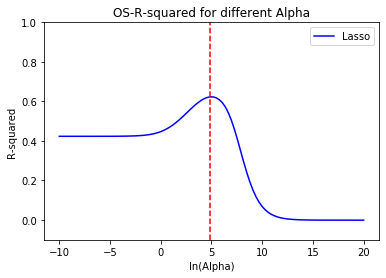

Optimal alpha for Lasso=127.54699035257418, best OS R_2=0.6230051765753224


In [62]:
alphas = np.exp(np.linspace(-10,20,100))
[alpha_optimal_L1, best_R2_L1, best_coefs_L1]=Regularization_fit_alpha(1,sc1,dataIncome1_mean,sc2,dataIncome2_mean,alphas,Graph=True,logl=True)
print('Optimal alpha for Lasso={0}, best OS R_2={1}'.format(alpha_optimal_L1,best_R2_L1))

In [63]:
Lasso=linear_model.Lasso(fit_intercept=True, alpha=alpha_optimal_L1)
Lasso.fit(sc1,dataIncome1_mean)

# In sample:
Mean_Pred_IS_Lasso=Lasso.predict(sc1)
print("The IS R-squared of Lasso is: {0}".format(r2_score(dataIncome1_mean,Mean_Pred_IS_Lasso)))
# Out of sample:
Mean_Pred_OS_Lasso=Lasso.predict(sc3)
print("The OS R-squared of Lasso is: {0}".format(r2_score(dataIncome3_mean,Mean_Pred_OS_Lasso)))
Lasso.coef_

The IS R-squared of Lasso is: 0.9986787136377954
The OS R-squared of Lasso is: 0.571074698856314


array([-0.00000000e+00,  0.00000000e+00,  1.37732697e+03,  1.72186108e+01,
       -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00, -1.55845468e+01,  0.00000000e+00, -0.00000000e+00,
        8.86990868e+01,  0.00000000e+00,  0.00000000e+00,  8.21776710e+03,
        1.06610911e+03,  0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,  3.24384947e+03,
       -1.37014167e+03, -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        2.10365679e+03,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -0.00000000e+00,  5.15890891e+02,
        7.14730681e+02, -2.97737846e+03, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -9.67279636e+02, -1.38925012e+03, -0.00000000e+00,
        3.04830849e+03, -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        2.41042487e+03, -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00,  

//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13369070.767275224, tolerance: 12932392.43693269
  positive)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15885612.157377124, tolerance: 12932392.43693269
  positive)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21811675.548193432, tolerance: 12932392.43693269
  positive)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27168354.

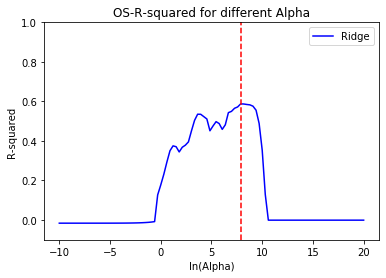

Optimal alpha for Ridge=2640.669807145078, best OS R_2=0.5875841317295658


In [64]:
alphas = np.exp(np.linspace(-10,20,100))
[alpha_optimal_L2, best_R2_L2, best_coefs_L2]=Regularization_fit_alpha(2,sc1,dataIncome1_mean,sc2,dataIncome2_mean,alphas,Graph=True,logl=True)
print('Optimal alpha for Ridge={0}, best OS R_2={1}'.format(alpha_optimal_L2,best_R2_L2))

In [65]:
Ridge=linear_model.Ridge(fit_intercept=True, alpha=alpha_optimal_L2)
Ridge.fit(sc1,dataIncome1_mean)

# In sample:
Mean_Pred_IS_Ridge=Ridge.predict(sc1)
print("The IS R-squared of Ridge is: {0}".format(r2_score(dataIncome1_mean,Mean_Pred_IS_Ridge)))
# Out of sample:
Mean_Pred_OS_Ridge=Ridge.predict(sc3)
print("The OS R-squared of Ridge is: {0}".format(r2_score(dataIncome3_mean,Mean_Pred_OS_Ridge)))
Ridge.coef_

The IS R-squared of Ridge is: 0.4108666830542862
The OS R-squared of Ridge is: 0.399171111967205


array([-423.64889788,   91.42546769,  447.59994051, -235.11761293,
         26.83905068,  146.97478789,  361.02066771,  421.6949905 ,
        -50.21528561,  105.38435505,  199.35160627, -263.14331458,
       -102.05394187,   47.28053079,  -60.82829939,  468.93901074,
        105.66233432,    0.        , -172.47559307,  -17.81572948,
       -327.37390455,   15.92569348,  -18.88074477,  319.53082004,
        -77.64200361,  193.99529767,  252.87869933, -175.54279746,
        299.58921131,  194.26881383,  -38.76651922,   -6.37530389,
        166.91268996, -116.60926597, -168.03387173, -144.74888865,
         14.1585987 , -291.94893943,    5.28268478,  262.3291456 ,
       -396.6420801 ,   52.10210531,  -81.18480092,  -53.38371609,
        391.43956073,  261.83891835,  319.97784766,  269.08399943,
        422.4476035 ,  297.06444957,  400.66158334,  410.42199908,
        232.89151859,  442.33255397, -181.51378335, -421.2537193 ,
         95.28774261, -231.75351111, -352.07567696, -169.75662

### It seems that with Lasso, R-squared IS is very high compared to the R-squared OS which might suggest that it is overfitting the training data. On the other hand, Ridge is struggling to force the coefs to be zero, the low R-squared suggest that Ridge is performing bad on both the training and testing data